# SETTING ENVIRONMENT


In [11]:
"""# mount the colab with google drive
from google.colab import drive
drive.mount('/content/drive')"""

"# mount the colab with google drive\nfrom google.colab import drive\ndrive.mount('/content/drive')"

In [12]:
# set folder tempat kerja (current working directory)
import os
cwd = "/Users/yusufpradana/Library/CloudStorage/OneDrive-Personal/Pekerjaan BMN/05. 2025/98_monitoring_berita/monitoring-berita"
#cwd = '/content/drive/MyDrive/Monitoring Berita'
os.chdir(cwd)

In [13]:
# Check and install wordcloud if needed
import subprocess
import sys

try:
    import wordcloud
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"], 
                         stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# MAIN

Module ini berfungsi untuk membuat visualisasi data atas output terakhir dari proses analisis yaitu analisis berita penting.

Dalam proses visualisasi data, module ini akan:
1. Membaca data output dari analisis berita penting yang path nya sudah tersimpan di config.json 
2. Mengolah data sesuai format yang diperlukan untuk visualisasi.
Jenis visualisasi: 
    * Pie chart sentimen berita
    * Time line sentimen berita per tanggal (positif, negatif, netral)
    * Word cloud dari berita yang muncul (menampilkan kata yang paling banyak muncul)
    * ide lain?
2. Membuat beberapa visualisasi yang dapat digunakan dalam laporan. 
3. Menampilkan visualisasi tersebut.

In [14]:
# PART 1: Import Libraries yang diperlukan

# Data manipulation
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Word cloud
from wordcloud import WordCloud

# Text processing (untuk word cloud)
import re
from collections import Counter

# System utilities
import os
import warnings
warnings.filterwarnings('ignore')

# Set style untuk matplotlib
plt.style.use('default')
sns.set_palette("husl")

# print("✅ Semua libraries berhasil diimport!")

In [15]:
# PART 2: Load Configurations dari config.json

def load_config():
    """
    Fungsi untuk memuat konfigurasi dari file config.json
    Returns: dictionary berisi konfigurasi
    """
    try:
        with open('config.json', 'r', encoding='utf-8') as f:
            config = json.load(f)
        print("✅ Konfigurasi berhasil dimuat dari config.json")
        return config
    except FileNotFoundError:
        print("❌ File config.json tidak ditemukan!")
        return None
    except json.JSONDecodeError as e:
        print(f"❌ Error parsing JSON: {e}")
        return None

# Load konfigurasi
config = load_config()

if config:
    """print("\n📋 Informasi Konfigurasi:")
    print(f"   • Search dates: {len(config.get('search_date', []))} tanggal")
    print(f"   • Keywords: {config.get('keywords', [])}")
    print(f"   • AI model: {config.get('AI_name', 'N/A')}")
    print(f"   • Last update berita penting: {config.get('berita_penting_last_updated', 'N/A')}")"""
    
    # Path file berita penting (yang akan divisualisasikan)
    berita_penting_path = config.get('berita_penting_output_absolute')
    print(f"   • Path berita penting: {berita_penting_path}")
    
    # Cek apakah file ada
    if berita_penting_path and os.path.exists(berita_penting_path):
        print("   ✅ File berita penting tersedia")
    else:
        print("   ❌ File berita penting tidak ditemukan!")
else:
    print("❌ Gagal memuat konfigurasi!")

✅ Konfigurasi berhasil dimuat dari config.json
   • Path berita penting: /Users/yusufpradana/Library/CloudStorage/OneDrive-Personal/Pekerjaan BMN/05. 2025/98_monitoring_berita/monitoring-berita/00_hasil_analisis/berita_penting/analisis_berita_penting_deepseek_20251006_085153.csv
   ✅ File berita penting tersedia


In [16]:
# PART 3: Load Data Berita Penting dari path di config.json

def load_berita_penting_data(config):
    """
    Fungsi untuk memuat data berita penting dari CSV
    Returns: DataFrame berisi data berita penting
    """
    if not config:
        print("❌ Konfigurasi tidak tersedia!")
        return None
        
    berita_penting_path = config.get('berita_penting_output_absolute')
    
    if not berita_penting_path:
        print("❌ Path file berita penting tidak ditemukan di konfigurasi!")
        return None
        
    if not os.path.exists(berita_penting_path):
        print(f"❌ File tidak ditemukan: {berita_penting_path}")
        return None
        
    try:
        # Load data dengan encoding UTF-8
        df = pd.read_csv(berita_penting_path, encoding='utf-8')
        print("✅ Data berita penting berhasil dimuat!")
        
        """# Info dasar dataset
        print(f"\n📊 Informasi Dataset:")
        print(f"   • Total berita: {len(df)} artikel")
        print(f"   • Kolom data: {len(df.columns)} kolom")
        print(f"   • Rentang tanggal: {df['tanggal_berita_norm'].min()} - {df['tanggal_berita_norm'].max()}")
        
        # Distribusi sentimen
        if 'sentimen' in df.columns:
            sentimen_counts = df['sentimen'].value_counts()
            print(f"\n📈 Distribusi Sentimen:")
            for sentimen, count in sentimen_counts.items():
                persen = (count/len(df))*100
                print(f"   • {sentimen.title()}: {count} berita ({persen:.1f}%)")
        
        # Distribusi topik
        if 'topik_llm' in df.columns:
            topik_counts = df['topik_llm'].value_counts()
            print(f"\n🏷️ Distribusi Topik:")
            for topik, count in topik_counts.head().items():
                print(f"   • {topik}: {count} berita")
                
        # Distribusi source domain
        if 'source_domain' in df.columns:
            source_counts = df['source_domain'].value_counts()
            print(f"\n🌐 Top 5 Media Sources:")
            for source, count in source_counts.head().items():
                print(f"   • {source}: {count} berita")"""
        
        return df
        
    except Exception as e:
        print(f"❌ Error saat memuat data: {e}")
        return None

# Load data berita penting
df_berita = load_berita_penting_data(config)

# Jika data berhasil dimuat, tampilkan sample data
if df_berita is not None:
    """print(f"\n📋 Sample Data (5 baris pertama):")
    print("="*80)
    
    # Kolom utama yang akan ditampilkan
    display_cols = ['judul_berita', 'tanggal_berita_norm', 'sentimen', 'topik_llm', 'source_domain']
    available_cols = [col for col in display_cols if col in df_berita.columns]
    
    # Tampilkan sample dengan kolom yang tersedia
    sample_df = df_berita[available_cols].head()
    for idx, row in sample_df.iterrows():
        print(f"\n📰 Berita {idx+1}:")
        for col in available_cols:
            if col == 'judul_berita':
                # Truncate judul jika terlalu panjang
                judul = row[col][:100] + "..." if len(str(row[col])) > 100 else row[col]
                print(f"   📝 Judul: {judul}")
            elif col == 'tanggal_berita_norm':
                print(f"   📅 Tanggal: {row[col]}")
            elif col == 'sentimen':
                emoji = "😊" if row[col] == "positif" else "😠" if row[col] == "negatif" else "😐"
                print(f"   {emoji} Sentimen: {row[col]}")
            elif col == 'topik_llm':
                print(f"   🏷️ Topik: {row[col]}")
            elif col == 'source_domain':
                print(f"   🌐 Media: {row[col]}")
        print("-" * 60)"""
    
    print(f"\n✅ Data siap untuk divisualisasikan!")
else:
    print("\n❌ Tidak dapat melanjutkan ke visualisasi karena data tidak berhasil dimuat.")

✅ Data berita penting berhasil dimuat!

✅ Data siap untuk divisualisasikan!


### PART VISUALISASI

In [17]:
# PART 4: Preprocessing Data untuk Visualisasi

def preprocess_data_for_visualization(df):
    """
    Fungsi untuk memproses data berita untuk keperluan visualisasi
    Returns: Dictionary berisi data yang sudah diproses
    """
    if df is None or df.empty:
        print("❌ DataFrame kosong atau None!")
        return None
    
    print("🔄 Memulai preprocessing data untuk visualisasi...")
    
    # 1. Konversi format tanggal
    print("📅 Konversi format tanggal...")
    df_processed = df.copy()
    
    # Convert tanggal_berita_norm to datetime
    try:
        df_processed['tanggal_datetime'] = pd.to_datetime(df_processed['tanggal_berita_norm'])
        df_processed['tanggal_str'] = df_processed['tanggal_datetime'].dt.strftime('%Y-%m-%d')
        df_processed['hari_nama'] = df_processed['tanggal_datetime'].dt.day_name()
        print("   ✅ Konversi tanggal berhasil")
    except Exception as e:
        print(f"   ❌ Error konversi tanggal: {e}")
        return None
    
    # 2. Cleaning dan normalisasi teks untuk word cloud
    print("🧹 Cleaning teks untuk word cloud...")
    
    def clean_text_for_wordcloud(text):
        """Fungsi untuk membersihkan teks untuk word cloud"""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = str(text).lower()
        
        # Remove URLs
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove numbers and special characters, keep only letters and spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        # Remove extra whitespaces
        text = ' '.join(text.split())
        
        # Remove common stop words in Indonesian
        stop_words = {
            'yang', 'dan', 'di', 'dari', 'ke', 'untuk', 'dengan', 'pada', 'dalam', 'oleh', 
            'akan', 'adalah', 'telah', 'sudah', 'ini', 'itu', 'tersebut', 'juga', 'atau',
            'tidak', 'bukan', 'dapat', 'bisa', 'harus', 'ada', 'satu', 'dua', 'tiga',
            'kami', 'kita', 'mereka', 'dia', 'ia', 'anda', 'saya', 'kamu', 'nya',
            'bahwa', 'jika', 'ketika', 'karena', 'sehingga', 'maka', 'tetapi', 'namun',
            'menjadi', 'memberikan', 'melakukan', 'memiliki', 'mengatakan', 'berkata',
            'news', 'berita', 'com', 'co', 'id', 'www', 'loading', 'read', 'artikel'
        }
        
        # Remove stop words
        words = text.split()
        words = [word for word in words if word not in stop_words and len(word) > 2]
        
        return ' '.join(words)
    
    # Apply text cleaning
    if 'judul_berita' in df_processed.columns:
        df_processed['judul_clean'] = df_processed['judul_berita'].apply(clean_text_for_wordcloud)
    
    if 'artikel_berita_bersih' in df_processed.columns:
        df_processed['artikel_clean'] = df_processed['artikel_berita_bersih'].apply(clean_text_for_wordcloud)
    
    print("   ✅ Text cleaning berhasil")
    
    # 3. Grouping data berdasarkan tanggal, sentimen, topik
    print("📊 Grouping data untuk analisis...")
    
    # Group by tanggal dan sentimen
    daily_sentiment = df_processed.groupby(['tanggal_str', 'sentimen']).size().reset_index(name='count')
    
    # Group by sentimen saja
    sentiment_summary = df_processed['sentimen'].value_counts().reset_index()
    sentiment_summary.columns = ['sentimen', 'count']
    sentiment_summary['percentage'] = (sentiment_summary['count'] / len(df_processed)) * 100
    
    # Group by topik
    if 'topik_llm' in df_processed.columns:
        topic_summary = df_processed['topik_llm'].value_counts().reset_index()
        topic_summary.columns = ['topik', 'count']
        topic_summary['percentage'] = (topic_summary['count'] / len(df_processed)) * 100
    else:
        topic_summary = pd.DataFrame()
    
    # Group by source domain
    if 'source_domain' in df_processed.columns:
        source_summary = df_processed['source_domain'].value_counts().head(10).reset_index()
        source_summary.columns = ['media', 'count']
        source_summary['percentage'] = (source_summary['count'] / len(df_processed)) * 100
    else:
        source_summary = pd.DataFrame()
    
    print("   ✅ Grouping data berhasil")
    
    # 4. Perhitungan statistik untuk visualisasi
    print("📈 Perhitungan statistik...")
    
    # Timeline data (per tanggal)
    date_range = pd.date_range(start=df_processed['tanggal_datetime'].min(), 
                              end=df_processed['tanggal_datetime'].max(), 
                              freq='D')
    
    # Create complete timeline with all sentiments
    timeline_data = []
    sentiments = ['positif', 'negatif', 'netral']
    
    for date in date_range:
        date_str = date.strftime('%Y-%m-%d')
        for sentiment in sentiments:
            count = len(df_processed[(df_processed['tanggal_str'] == date_str) & 
                                   (df_processed['sentimen'] == sentiment)])
            timeline_data.append({
                'tanggal': date_str,
                'sentimen': sentiment,
                'count': count
            })
    
    timeline_df = pd.DataFrame(timeline_data)
    
    # Word frequency untuk word cloud
    word_freq = {}
    if 'judul_clean' in df_processed.columns:
        all_titles = ' '.join(df_processed['judul_clean'].dropna())
        words = all_titles.split()
        word_counts = Counter(words)
        # Filter words dengan minimal 2 karakter dan muncul minimal 2 kali
        word_freq = {word: count for word, count in word_counts.items() 
                    if len(word) > 2 and count >= 2}
    
    print("   ✅ Statistik berhasil dihitung")
    
    # Compile semua hasil
    processed_data = {
        'df_original': df,
        'df_processed': df_processed,
        'daily_sentiment': daily_sentiment,
        'sentiment_summary': sentiment_summary,
        'topic_summary': topic_summary,
        'source_summary': source_summary,
        'timeline_data': timeline_df,
        'word_frequency': word_freq,
        'date_range': {
            'start': df_processed['tanggal_datetime'].min(),
            'end': df_processed['tanggal_datetime'].max(),
            'total_days': len(date_range)
        },
        'stats': {
            'total_articles': len(df_processed),
            'unique_dates': df_processed['tanggal_str'].nunique(),
            'unique_sources': df_processed['source_domain'].nunique() if 'source_domain' in df_processed.columns else 0,
            'avg_articles_per_day': len(df_processed) / len(date_range)
        }
    }
    
    print("✅ Preprocessing selesai!")
    print(f"\n📋 Ringkasan Data Processed:")
    print(f"   • Total artikel: {processed_data['stats']['total_articles']}")
    print(f"   • Rentang tanggal: {processed_data['stats']['unique_dates']} hari")
    print(f"   • Rata-rata artikel/hari: {processed_data['stats']['avg_articles_per_day']:.1f}")
    print(f"   • Jumlah media: {processed_data['stats']['unique_sources']}")
    print(f"   • Kata unik untuk word cloud: {len(word_freq)}")
    
    return processed_data

# Jalankan preprocessing jika data tersedia
if 'df_berita' in locals() and df_berita is not None:
    processed_data = preprocess_data_for_visualization(df_berita)
    
    if processed_data:
        print(f"\n🎯 Data siap untuk visualisasi!")
        print(f"   📊 Sentiment distribution: {len(processed_data['sentiment_summary'])} kategori")
        print(f"   📅 Timeline data: {len(processed_data['timeline_data'])} data points")
        print(f"   🏷️ Topic data: {len(processed_data['topic_summary'])} topik")
        print(f"   🌐 Media sources: {len(processed_data['source_summary'])} media")
    else:
        print("❌ Preprocessing gagal!")
else:
    print("❌ Data berita tidak tersedia. Jalankan Part 3 terlebih dahulu.")

🔄 Memulai preprocessing data untuk visualisasi...
📅 Konversi format tanggal...
   ✅ Konversi tanggal berhasil
🧹 Cleaning teks untuk word cloud...
   ✅ Text cleaning berhasil
📊 Grouping data untuk analisis...
   ✅ Grouping data berhasil
📈 Perhitungan statistik...
   ✅ Statistik berhasil dihitung
✅ Preprocessing selesai!

📋 Ringkasan Data Processed:
   • Total artikel: 119
   • Rentang tanggal: 2 hari
   • Rata-rata artikel/hari: 59.5
   • Jumlah media: 85
   • Kata unik untuk word cloud: 208

🎯 Data siap untuk visualisasi!
   📊 Sentiment distribution: 3 kategori
   📅 Timeline data: 6 data points
   🏷️ Topic data: 3 topik
   🌐 Media sources: 10 media


In [18]:
# PART 5: Fungsi-fungsi Visualisasi

def create_sentiment_pie_chart(processed_data, title="Distribusi Sentimen Berita"):
    """
    Membuat pie chart untuk distribusi sentimen
    """
    sentiment_data = processed_data['sentiment_summary']
    
    # Color mapping untuk sentimen
    colors = {
        'positif': '#2E8B57',  # Green
        'negatif': '#DC143C',   # Red  
        'netral': '#808080'     # Gray
    }
    
    fig = go.Figure(data=[go.Pie(
        labels=sentiment_data['sentimen'],
        values=sentiment_data['count'],
        hole=0.4,
        marker=dict(colors=[colors.get(s, '#808080') for s in sentiment_data['sentimen']]),
        textinfo='label+percent+value',
        textposition='outside',
        hovertemplate='<b>%{label}</b><br>Jumlah: %{value}<br>Persentase: %{percent}<extra></extra>'
    )])
    
    fig.update_layout(
        showlegend=True,
        width=700,
        height=500,
        font=dict(size=12),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    return fig

def create_timeline_chart(processed_data, title="Timeline Sentimen Berita Harian"):
    """
    Membuat line chart timeline sentimen per hari
    """
    timeline_data = processed_data['timeline_data']
    
    # Color mapping
    colors = {
        'positif': '#2E8B57',
        'negatif': '#DC143C', 
        'netral': '#808080'
    }
    
    fig = go.Figure()
    
    # Add line untuk setiap sentimen
    for sentiment in ['positif', 'negatif', 'netral']:
        sentiment_data = timeline_data[timeline_data['sentimen'] == sentiment]
        
        fig.add_trace(go.Scatter(
            x=sentiment_data['tanggal'],
            y=sentiment_data['count'],
            mode='lines+markers+text',
            name=sentiment.title(),
            line=dict(color=colors[sentiment], width=3),
            marker=dict(size=8),
            text=sentiment_data['count'],
            textposition='top center',
            textfont=dict(size=10, color=colors[sentiment]),
            hovertemplate=f'<b>{sentiment.title()}</b><br>Tanggal: %{{x}}<br>Jumlah: %{{y}}<extra></extra>'
        ))
    
    fig.update_layout(
        xaxis_title="Tanggal",
        yaxis_title="Jumlah Berita",
        width=700,
        height=500,
        hovermode='x unified',
        font=dict(size=12),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    return fig

def create_media_source_chart(processed_data, title="Top 10 Media Sources"):
    """
    Membuat horizontal bar chart untuk media sources
    """
    source_data = processed_data['source_summary'].head(10)
    
    # Create color list: dark blue for top 3, light blue for the rest
    colors = []
    for i in range(len(source_data)):
        if i < 3:  # Top 3 media
            colors.append('#1E3A8A')  # Dark blue
        else:  # Other media
            colors.append('#87CEEB')  # Light blue
    
    fig = go.Figure(data=[go.Bar(
        x=source_data['count'],
        y=source_data['media'],
        orientation='h',
        marker=dict(color=colors),
        text=source_data['count'],
        textposition='outside',
        hovertemplate='<b>%{y}</b><br>Jumlah berita: %{x}<br>Persentase: %{customdata:.1f}%<extra></extra>',
        customdata=source_data['percentage']
    )])
    
    fig.update_layout(
        xaxis_title="Jumlah Berita",
        yaxis_title="Media Source",
        width=700,
        height=500,
        yaxis=dict(autorange='reversed'),  # Top media di atas
        font=dict(size=12),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    return fig

def create_wordcloud(processed_data, title="Word Cloud - Kata Kunci Berita"):
    """
    Membuat word cloud dari kata-kata yang sering muncul
    """
    word_freq = processed_data['word_frequency']
    
    if not word_freq:
        print("❌ Tidak ada data untuk word cloud")
        return None
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=50,
        relative_scaling=0.5,
        min_font_size=10
    ).generate_from_frequencies(word_freq)
    
    # Plot menggunakan matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    
    return plt.gcf()

def create_daily_summary_chart(processed_data, title="Ringkasan Berita Harian"):
    """
    Membuat stacked bar chart ringkasan harian
    """
    # Aggregate data per tanggal
    daily_summary = processed_data['timeline_data'].groupby('tanggal')['count'].sum().reset_index()
    daily_sentiment = processed_data['timeline_data'].pivot(index='tanggal', columns='sentimen', values='count').fillna(0)
    
    colors = {
        'positif': '#2E8B57',
        'negatif': '#DC143C',
        'netral': '#808080'
    }
    
    fig = go.Figure()
    
    # Add bars untuk setiap sentimen
    for sentiment in ['positif', 'negatif', 'netral']:
        if sentiment in daily_sentiment.columns:
            # Only show text label if count > 0
            text_values = [str(int(val)) if val > 0 else '' for val in daily_sentiment[sentiment]]
            
            fig.add_trace(go.Bar(
                x=daily_sentiment.index,
                y=daily_sentiment[sentiment],
                name=sentiment.title(),
                marker=dict(color=colors[sentiment]),
                text=text_values,
                textposition='inside',
                textfont=dict(size=10, color='white'),
                hovertemplate=f'<b>{sentiment.title()}</b><br>Tanggal: %{{x}}<br>Jumlah: %{{y}}<extra></extra>'
            ))
    
    fig.update_layout(
        xaxis_title="Tanggal",
        yaxis_title="Jumlah Berita",
        barmode='stack',
        width=700,
        height=500,
        font=dict(size=12),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    return fig

def create_media_sentiment_heatmap(processed_data, title="Heatmap Sentimen Harian per Media"):
    """
    Membuat heatmap yang menunjukkan distribusi sentimen per media per tanggal
    """
    df_processed = processed_data['df_processed']
    
    # Ambil top 10 media untuk readability
    top_media = processed_data['source_summary'].head(10)['media'].tolist()
    df_filtered = df_processed[df_processed['source_domain'].isin(top_media)]
    
    # Create pivot table untuk heatmap
    # Menghitung persentase sentimen positif per media per tanggal
    media_date_sentiment = df_filtered.groupby(['source_domain', 'tanggal_str', 'sentimen']).size().unstack(fill_value=0)
    
    # Calculate percentage of positive sentiment for each media-date combination
    # PENTING: Hanya hitung persentase jika ada berita (sum > 0)
    media_sentiment_pct = media_date_sentiment.div(media_date_sentiment.sum(axis=1), axis=0) * 100
    
    # Replace NaN with NaN (bukan 0) untuk hari tanpa berita
    media_sentiment_pct = media_sentiment_pct.where(media_date_sentiment.sum(axis=1) > 0)
    
    # Focus on positive sentiment percentage for the heatmap
    if 'positif' in media_sentiment_pct.columns:
        positive_pct = media_sentiment_pct['positif'].unstack(level='tanggal_str')
    else:
        # If no positive sentiment data, create empty DataFrame
        dates = df_processed['tanggal_str'].unique()
        positive_pct = pd.DataFrame(np.nan, index=top_media, columns=dates)
    
    # Ensure all media and all dates are represented
    all_dates = df_processed['tanggal_str'].unique()
    positive_pct = positive_pct.reindex(index=top_media, columns=all_dates)
    
    # Create heatmap
    # Handle NaN values properly - show as gray for "no data"
    heatmap_data = positive_pct.values.copy()
    
    fig = go.Figure(data=go.Heatmap(
        z=heatmap_data,
        x=positive_pct.columns,
        y=positive_pct.index,
        colorscale=[
            [0, '#DC143C'],      # Red for 0% positive (all negative/neutral)
            [0.5, '#808080'],    # Gray for 50% positive (balanced sentiment)
            [1, '#2E8B57']       # Green for 100% positive
        ],
        zmid=50,  # Set midpoint at 50%
        zmin=0,   # Minimum value 0%
        zmax=100, # Maximum value 100%
        colorbar=dict(
            title="% Sentimen Positif",
            titleside="right",
            ticksuffix="%"
        ),
        # Custom hover text to handle NaN properly
        hovertemplate='<b>%{y}</b><br>Tanggal: %{x}<br>' + 
                     '<extra></extra>',
        customdata=positive_pct.values,
        text=[[f"Sentimen Positif: {val:.1f}%" if not pd.isna(val) else "Tidak ada berita" 
               for val in row] for row in positive_pct.values],
        hovertext=[[f"Sentimen Positif: {val:.1f}%" if not pd.isna(val) else "Tidak ada berita" 
                   for val in row] for row in positive_pct.values],
        hoverinfo='text'
    ))
    
    fig.update_layout(
        xaxis_title="Tanggal",
        yaxis_title="Media Source",
        width=700,
        height=500,
        font=dict(size=12),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    return fig

def display_all_visualizations(processed_data):
    """
    Menampilkan semua visualisasi
    """
    print("🎨 Membuat dan menampilkan visualisasi...")
    
    # 1. Pie Chart Sentimen
    print("\n📊 1. Pie Chart - Distribusi Sentimen")
    fig1 = create_sentiment_pie_chart(processed_data)
    fig1.show()
    
    # 2. Timeline Chart  
    print("\n📈 2. Line Chart - Timeline Sentimen Harian")
    fig2 = create_timeline_chart(processed_data)
    fig2.show()
    
    # 3. Daily Summary Stacked Bar
    print("\n📋 3. Stacked Bar Chart - Ringkasan Harian")
    fig3 = create_daily_summary_chart(processed_data)
    fig3.show()
    
    # 4. Media Sources Chart
    print("\n🌐 4. Bar Chart - Top Media Sources")
    fig4 = create_media_source_chart(processed_data)
    fig4.show()
    
    # 5. Media Sentiment Heatmap
    print("\n🔥 5. Heatmap - Sentimen per Media per Tanggal")
    fig5 = create_media_sentiment_heatmap(processed_data)
    fig5.show()
    
    # 6. Word Cloud
    print("\n☁️ 6. Word Cloud - Kata Kunci Populer")
    fig6 = create_wordcloud(processed_data)
    if fig6:
        plt.show()
    
    print("\n✅ Semua visualisasi telah ditampilkan!")
    
    return {
        'sentiment_pie': fig1,
        'timeline': fig2, 
        'daily_summary': fig3,
        'media_sources': fig4,
        'media_sentiment_heatmap': fig5,
        'wordcloud': fig6
    }

print("✅ Fungsi-fungsi visualisasi telah didefinisikan!")

✅ Fungsi-fungsi visualisasi telah didefinisikan!


🚀 Memulai pembuatan semua visualisasi...
📊 Dataset Overview:
   • Periode: 2025-10-05 - 2025-10-06
   • Total berita: 119 artikel
   • Rata-rata per hari: 59.5 artikel
   • Jumlah media: 85 media
🎨 Membuat dan menampilkan visualisasi...

📊 1. Pie Chart - Distribusi Sentimen



📈 2. Line Chart - Timeline Sentimen Harian



📋 3. Stacked Bar Chart - Ringkasan Harian



🌐 4. Bar Chart - Top Media Sources



🔥 5. Heatmap - Sentimen per Media per Tanggal



☁️ 6. Word Cloud - Kata Kunci Populer


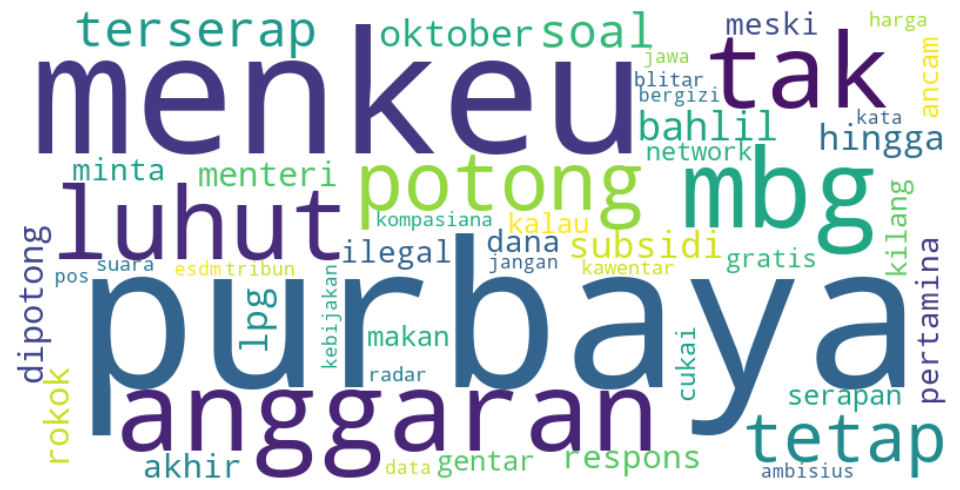


✅ Semua visualisasi telah ditampilkan!

📋 Insight Utama:
   🎯 Sentimen dominan: netral (67.2%)
   📺 Media terbanyak: news.ambisius.com (5 berita)
   🔤 Kata populer: purbaya (105), menkeu (72), anggaran (53), mbg (51), tak (45)

✅ Semua visualisasi berhasil dibuat dan ditampilkan!
💡 Tip: Scroll ke atas untuk melihat grafik-grafik yang telah dibuat.


In [19]:
# PART 6: Eksekusi Visualisasi

# Jalankan semua visualisasi jika data sudah diproses
if 'processed_data' in locals() and processed_data is not None:
    print("🚀 Memulai pembuatan semua visualisasi...")
    print("="*60)
    
    # Tampilkan info singkat terlebih dahulu
    stats = processed_data['stats']
    print(f"📊 Dataset Overview:")
    print(f"   • Periode: {processed_data['date_range']['start'].strftime('%Y-%m-%d')} - {processed_data['date_range']['end'].strftime('%Y-%m-%d')}")
    print(f"   • Total berita: {stats['total_articles']} artikel")
    print(f"   • Rata-rata per hari: {stats['avg_articles_per_day']:.1f} artikel")
    print(f"   • Jumlah media: {stats['unique_sources']} media")
    print("="*60)
    
    # Tampilkan semua visualisasi
    charts = display_all_visualizations(processed_data)
    
    # Summary informasi tambahan
    print(f"\n📋 Insight Utama:")
    sentiment_summary = processed_data['sentiment_summary']
    
    # Sentimen dominan
    top_sentiment = sentiment_summary.iloc[0]
    print(f"   🎯 Sentimen dominan: {top_sentiment['sentimen']} ({top_sentiment['percentage']:.1f}%)")
    
    # Media terpopuler
    if len(processed_data['source_summary']) > 0:
        top_media = processed_data['source_summary'].iloc[0]
        print(f"   📺 Media terbanyak: {top_media['media']} ({top_media['count']} berita)")
    
    # Kata kunci terpopuler
    if processed_data['word_frequency']:
        top_words = sorted(processed_data['word_frequency'].items(), key=lambda x: x[1], reverse=True)[:5]
        top_word_list = [f"{word} ({count})" for word, count in top_words]
        print(f"   🔤 Kata populer: {', '.join(top_word_list)}")
    
    print(f"\n✅ Semua visualisasi berhasil dibuat dan ditampilkan!")
    print(f"💡 Tip: Scroll ke atas untuk melihat grafik-grafik yang telah dibuat.")
    
else:
    print("❌ Data belum diproses!")
    print("💡 Jalankan Part 3 dan Part 4 terlebih dahulu untuk memuat dan memproses data.")